<a href="https://colab.research.google.com/github/tguinot/difiq/blob/main/MC_correlated_assets_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo : simuler $n$ actifs Black-Scholes corrélés
---

Le but de ce TP est de simuler conjointement les trajectoires de $n$ actifs Black-Scholes corrélés suivant une matrice de corrélation $C$ donnée (pour être tout à fait précis, ce sont les log-rendements des $n$ actifs qui sont corrélés suivant la matrice $C$).

Sans perte de généralité, on supposera ici le taux $r$ constant et qu'il n'y a pas de dividendes sur les actifs simulés.

Etant donné $S_t^i$, la valeur de l'actif $i \in \{1,\dots,n\}$ à la date $t$ et $σ_i$ sa volatilité, la valeur de l'actif $i$ au pas de temps suivant (date $t+Δt$) est obtenue de la manière suivante :  

$$
S^i_{t+Δt} = S^i_t\exp\left(\left(r-\frac{\sigma_i^2}{2}\right)\Delta t+\sigma_i\sqrt{Δt}\; ɛ_i\right)
$$

où $ɛ_i$ est une variable gaussienne centrée réduite.

Pour simuler conjointement les $n$ actifs au pas de temps suivant, il suffit d'être en mesure de simuler un vecteur $ɛ = [ɛ_1,\dots,ɛ_n]$ de loi gaussiennes centrées réduites corrélées suivant notre matrice de corrélation $C$.

Comment faire, dans la mesure où dans les principaux langages de programmation on sait simuler des variables gaussiennes **indépendantes** ?

Réponse : utiliser la propriété suivante et la décomposition de Cholesky.

<br>

### Propriété      
Soit $A$ une matrice carrée de dimension $n$ et $x$ un vecteur aléatoire de dimension $n$ et de matrice de variance-covariance $V$. Alors le vecteur $Ax$ a pour matrice de variance-covariance $AVA^T$.

<br>

### Décomposition de Cholesky
Pour toute matrice $V$ symétrique définie positive, il existe une matrice $L$ triangulaire inférieure telle que $V=LL^T$.

<br>

### Simuler $n$ lois gaussiennes centrées réduites corrélées
Considérons la décomposition de Cholesky de la matrice de corrélation $C$ : $C = LL^T$, avec $L$ triangulaire inférieure.

Soit $x$ un vecteur de variables gaussiennes centrées réduites indépendantes. Sa matrice de variance-covariance est donc l'identité.

Alors d'après la propriété précédente, $ɛ = Lx$ a pour matrice de variance-covariance (et donc de corrélation car les variables sont réduites) $LIL^T=LL^T=C$.

Nous savons maintenant simuler un vecteur de variables gaussiennes centrées réduites corrélés suivant la corrélation $C$ à partir d'un vecteur de gaussiennes centrées réduites indépendantes.



## Définition des inputs

In [ ]:
# imports
import numpy as np
import math

# params
T = 1.
Nassets = 10
Nsimul  = 5*10**4
Nsteps  = 100
r = 0.02

# pour afficher en plus large sans saut de ligne...
np.set_printoptions(linewidth=400)

In [ ]:
# input vol vector (random)
vol_min = 0.15
vol_max = 0.30
vol = np.random.uniform(vol_min, vol_max, Nassets)
print("\nInput vols =", vol)


Input vols = [0.17965723 0.29180488 0.29172782 0.25218859 0.28307661 0.16439014 0.17997814 0.16625064 0.2483642  0.23729751]


In [ ]:
# input correl matrix (random)
correl_min = 0.3
correl_max = 0.7
correl = np.random.uniform(correl_min, correl_max, (Nassets, Nassets))
correl = (correl + correl.T) / 2. # make matrix symmetric
np.fill_diagonal(correl, 1.)

print("\nInput correls = ")
print(correl)


Input correls = 
[[1.         0.44813404 0.64168277 0.36620483 0.65634789 0.66063441 0.51094983 0.60387447 0.54668022 0.46474583]
 [0.44813404 1.         0.49079438 0.50657388 0.57495699 0.48194442 0.46169258 0.55833574 0.52243405 0.55244488]
 [0.64168277 0.49079438 1.         0.43957202 0.61378381 0.49666149 0.5401999  0.49532971 0.52262796 0.40946898]
 [0.36620483 0.50657388 0.43957202 1.         0.64326769 0.65399078 0.55326142 0.55398537 0.53842516 0.64278935]
 [0.65634789 0.57495699 0.61378381 0.64326769 1.         0.61157061 0.65627992 0.41651018 0.50707345 0.47035125]
 [0.66063441 0.48194442 0.49666149 0.65399078 0.61157061 1.         0.53469269 0.58104278 0.58419747 0.60500075]
 [0.51094983 0.46169258 0.5401999  0.55326142 0.65627992 0.53469269 1.         0.4577459  0.52997589 0.4079703 ]
 [0.60387447 0.55833574 0.49532971 0.55398537 0.41651018 0.58104278 0.4577459  1.         0.42508827 0.58872769]
 [0.54668022 0.52243405 0.52262796 0.53842516 0.50707345 0.58419747 0.52997589

## Génération des variables gaussiennes centrées réduites corrélées

In [ ]:
from scipy.linalg import cholesky

# generate correlated normal variables with Cholesky
L = cholesky(correl, lower=True)
normal = np.empty(shape=(Nassets, Nsteps, Nsimul))
for i in range(Nsteps) :
  	normal[:,i,:] = L.dot(np.random.normal(0, 1, (Nassets, Nsimul)))

A noter que Python permet en fait de générer directement des variables gaussiennes corrélées. On pourrait donc remplacer le bout de code ci-dessus par le code suivant (en commentaire) :

In [ ]:
# Generate correlated normal variables directly...

# normal = np.random.multivariate_normal(np.full(Nassets, 0.), correl, (Nsteps, Nsimul))
# normal = np.moveaxis(normal, -1, 0) # pour mettre la dimension actifs en premier

## Simulation des $n$ actifs corrélés

In [ ]:
S = np.empty(shape=(Nassets, Nsteps+1, Nsimul))
S[:,0,:] = 100.
dt = T / Nsteps
A = (r - 0.5*vol**2)*dt
B = vol * math.sqrt(dt)

for i in range(Nsteps) :
 	S[:,i+1,:] = S[:,i,:] * np.exp(A[:,np.newaxis] + B[:,np.newaxis] * normal[:,i,:])

Vérifions que le résultat obtenu est correct en calculant les forwards empiriques, les volatilités empiriques et la corrélation empirique et en les comparant aux inputs...

In [ ]:
print("\nInput forwards =", np.full(Nassets, 100*math.exp(r*T)))
print("Empirical forwards =", np.mean(S[:,-1,:], axis=1))

print("\nInput vols =", vol)
print("Empirical vols =", np.std(np.log(S[:,-1,:]), axis=1))

print("\nInput correls = ")
print(correl)
print("\nEmpirical correls = ")
print(np.corrcoef(np.log(S[:,-1,:])))



Input forwards = [102.020134 102.020134 102.020134 102.020134 102.020134 102.020134 102.020134 102.020134 102.020134 102.020134]
Empirical forwards = [102.06865169 101.87715027 102.03992268 102.09360441 102.13472976 102.05777029 102.02022891 102.02491165 102.00181099 102.03072001]

Input vols = [0.17965723 0.29180488 0.29172782 0.25218859 0.28307661 0.16439014 0.17997814 0.16625064 0.2483642  0.23729751]
Empirical vols = [0.17885817 0.29214426 0.29075685 0.25331115 0.2840005  0.16329672 0.17954574 0.16617007 0.24794728 0.23666886]

Input correls = 
[[1.         0.44813404 0.64168277 0.36620483 0.65634789 0.66063441 0.51094983 0.60387447 0.54668022 0.46474583]
 [0.44813404 1.         0.49079438 0.50657388 0.57495699 0.48194442 0.46169258 0.55833574 0.52243405 0.55244488]
 [0.64168277 0.49079438 1.         0.43957202 0.61378381 0.49666149 0.5401999  0.49532971 0.52262796 0.40946898]
 [0.36620483 0.50657388 0.43957202 1.         0.64326769 0.65399078 0.55326142 0.55398537 0.53842516 0.64

Regardons quelques unes des simulations graphiquement...

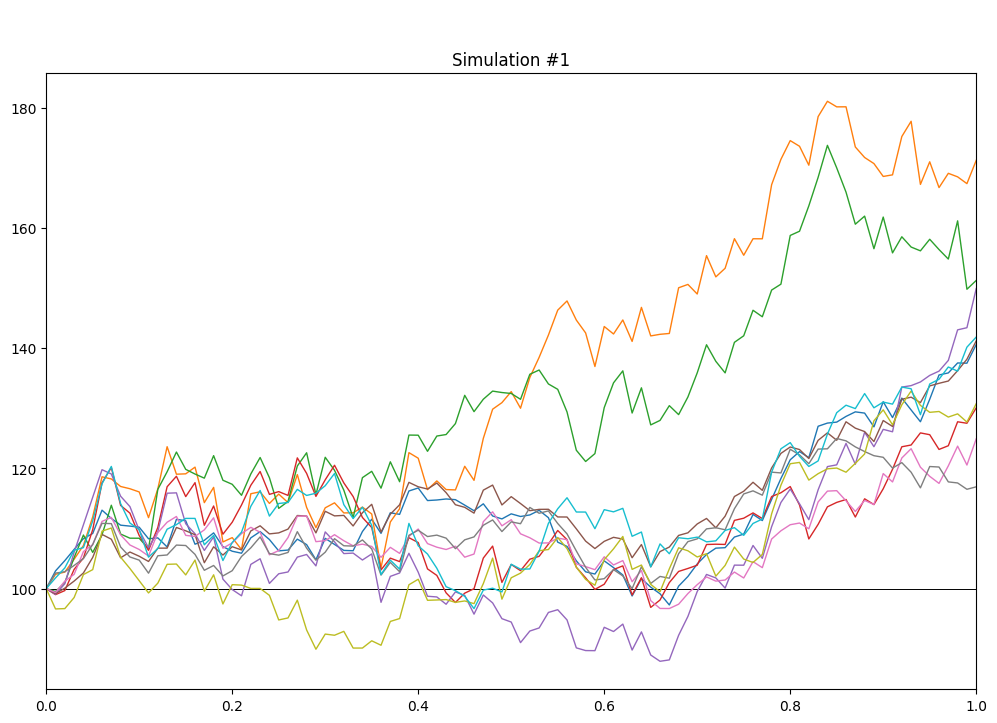

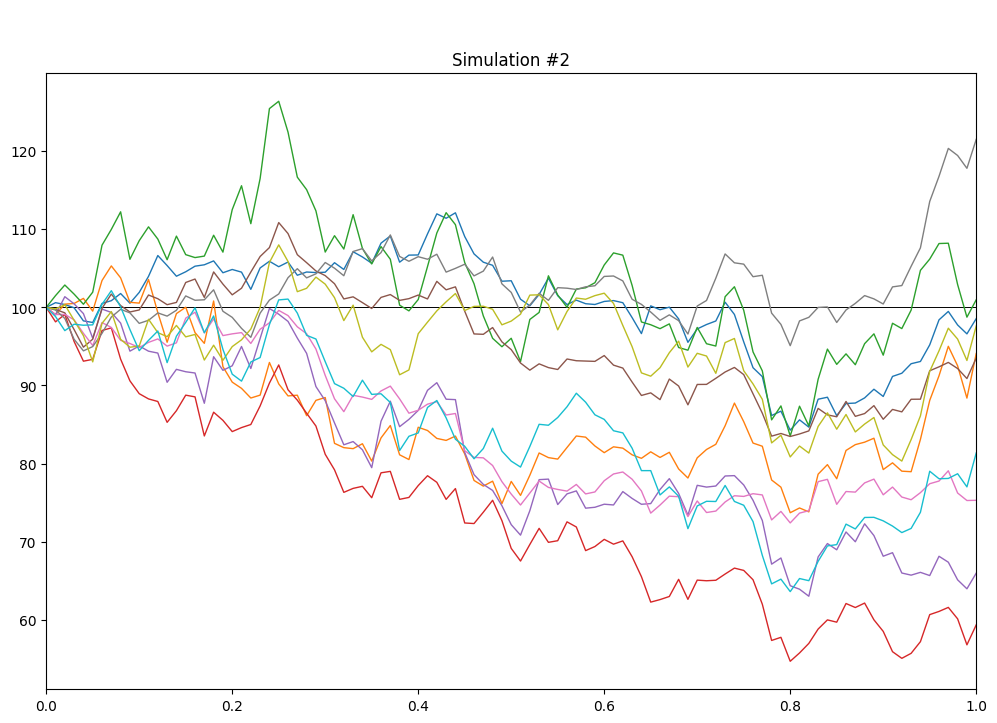

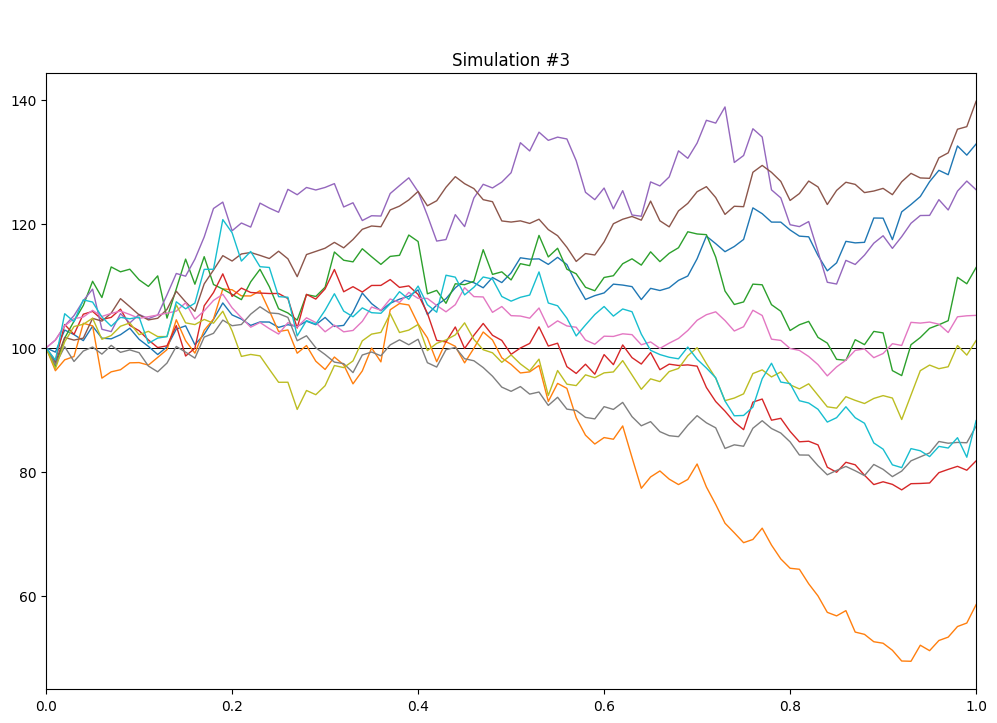

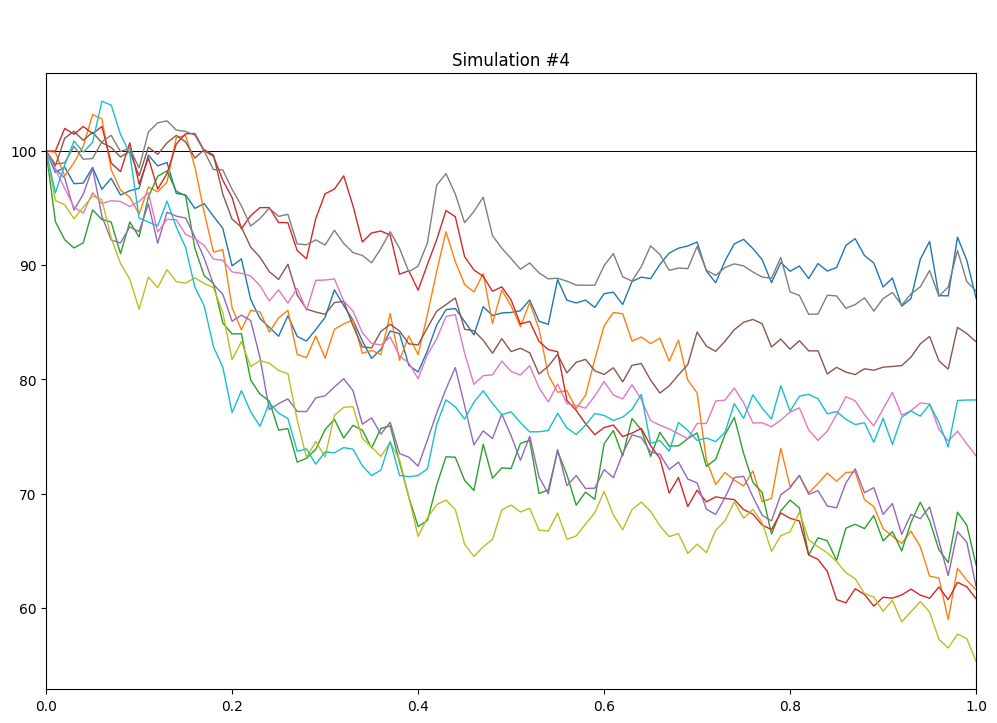

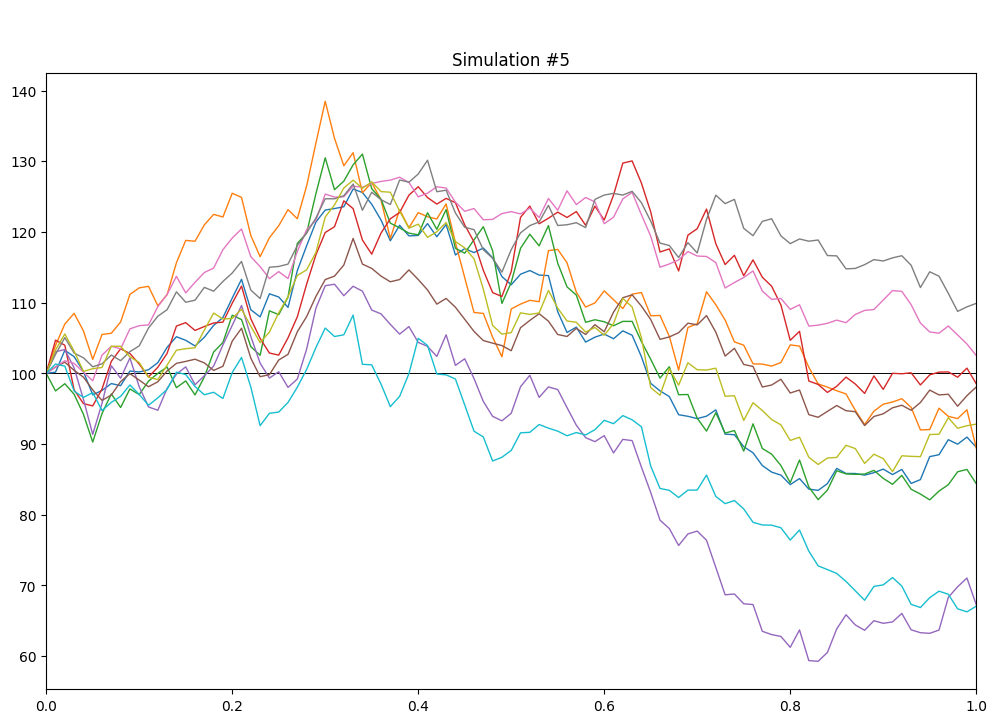

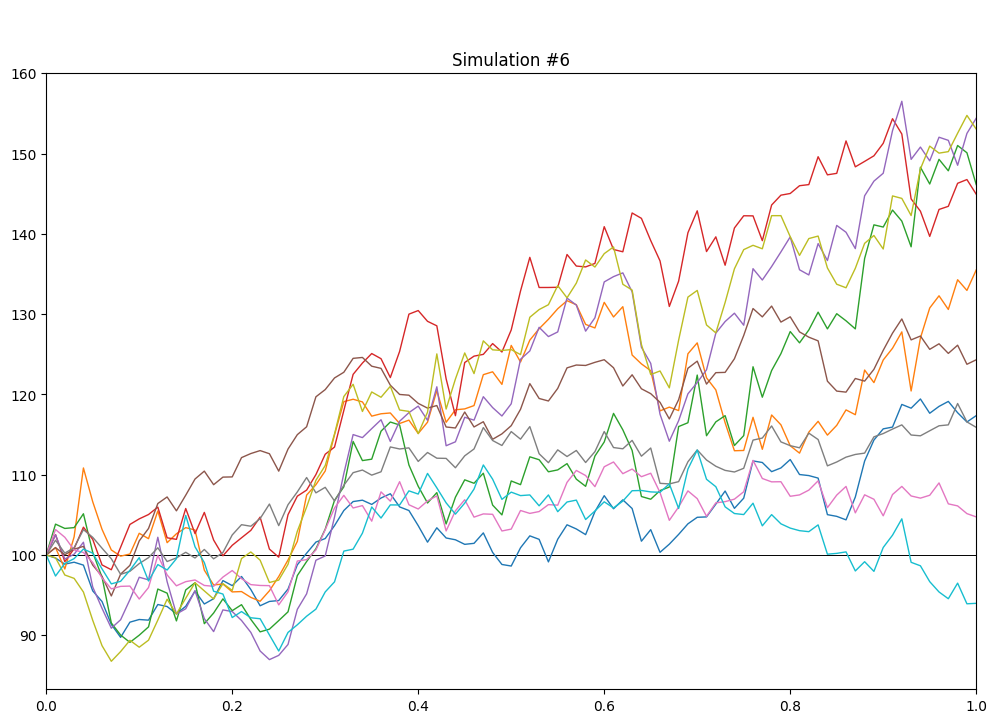

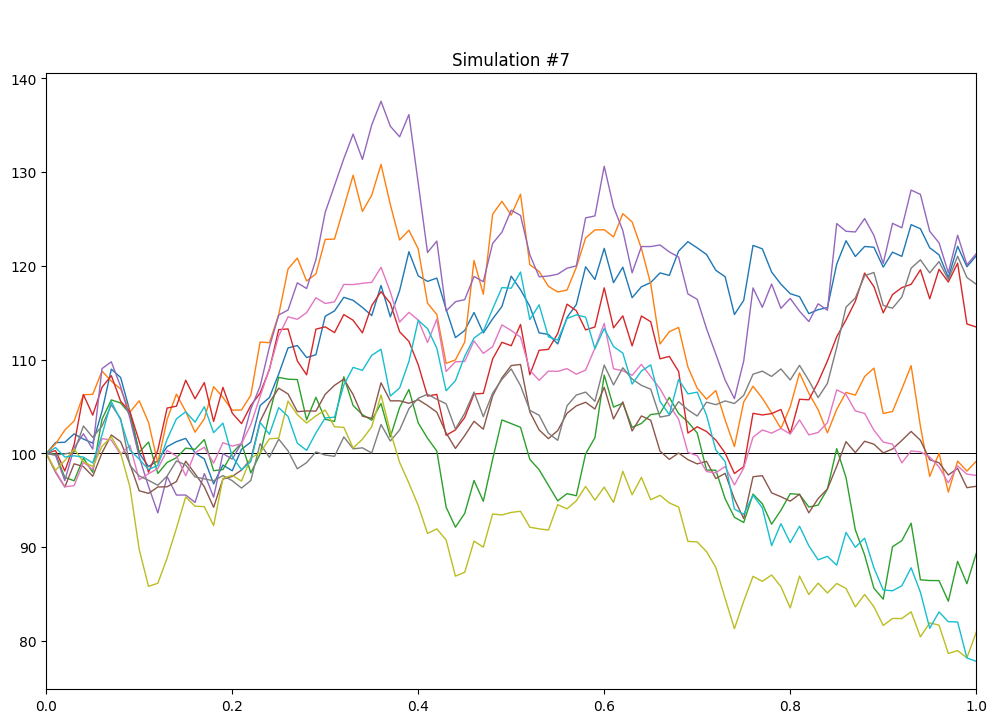

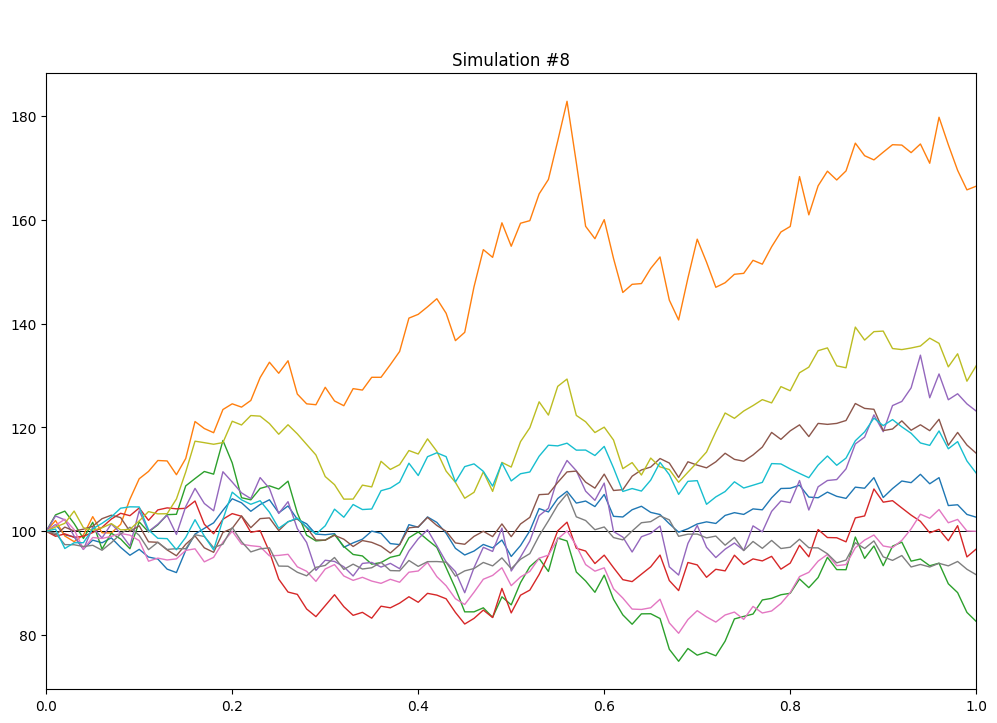

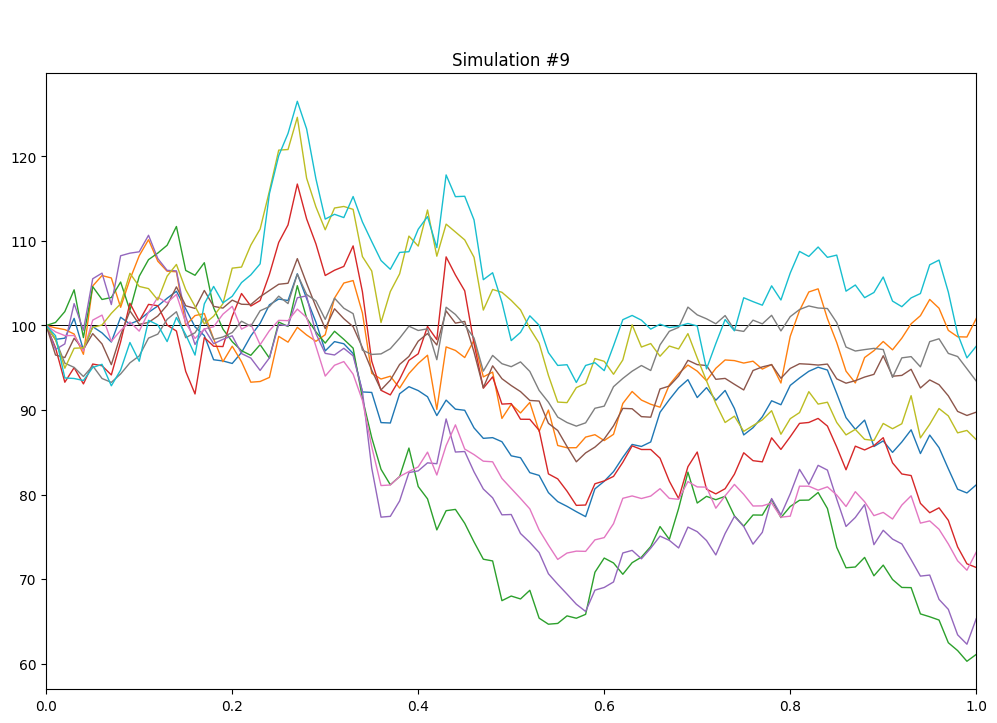

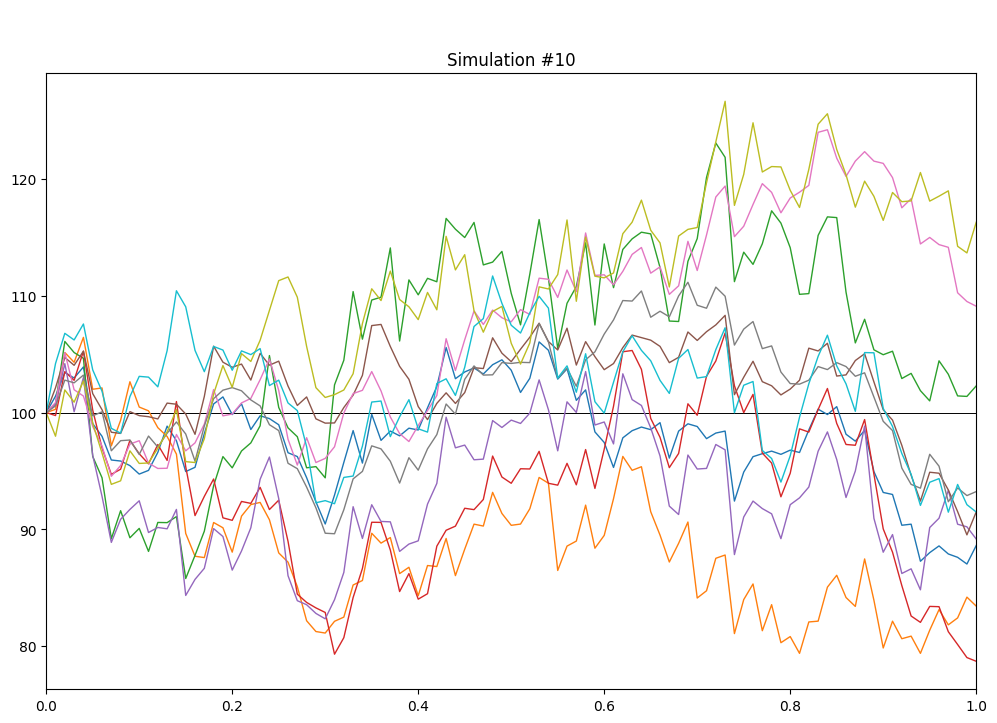

In [ ]:
# plot simulations
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
t = np.linspace(0, T, Nsteps+1, endpoint=True)

for i in range(10):
	plt.plot(t, np.full(len(t),100), linewidth=0.7, color="black")
	plt.xlim(0,T)
	for j in range(Nassets):
		plt.plot(t, S[j,:,i], linewidth=1)
		plt.title("\n\nSimulation #{}".format(i+1))
	plt.show()
